In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import sqlite3 as lite 

In [4]:
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Arial Narrow"

# Load compartments

In [5]:
treatments = ['NUT']
conditions = ['WT']
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h']

In [6]:
db_path = '../../data/ComplementaryData/HiC/TADbit_results/'

In [7]:
windows = [3]
ev_indexes = [1, 2]

In [9]:
hashs = {}
wjobids = {}
samples = []
for treatment in treatments:
    for condition in conditions:
        for time in times:
            sample = condition, treatment, time
            try:
                con = lite.connect(os.path.join(
                    db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}/trace.db'))
            except lite.OperationalError:
                print(f'Error {sample}')
                continue
            hashs[sample] = {}
            wjobids[sample] = {}
            samples.append(sample)
            cur = con.cursor()
            cur.execute("""
            select distinct Id, Parameters, Parameters_md5 from JOBs
            where Type = 'Segment' AND parameters like '%compartments:1%' AND not parameters like '%crms:[chrY]%'
            """)
            jobids = cur.fetchall()
            for window in windows:
                hashs[sample][window] = {}
                wjobids[sample][window] = {}
                for ev_index in ev_indexes:
                    if ev_index == 1:
                        test_ev = lambda x: 'ev_index:[2]' not in x
                    else:
                        test_ev = lambda x: 'ev_index:[2]' in x
                    hashs[sample][window][ev_index] = {}
                    wjobids[sample][window][ev_index] = {}
                    for jobid, parameters, md5 in jobids:
                        if (test_ev(parameters) and
                           f'smoothing_window:{window}' in parameters):
                            c = parameters.split('crms:[')[1].split(']')[0]
                            hashs[sample][window][ev_index][c] = md5
                            wjobids[sample][window][ev_index][c] = jobid
            con.close()
            con = lite.connect(os.path.join(
                db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}/trace.db'))
            cur = con.cursor()
            cur.execute("""
            select distinct JOBid, richA_corr from SEGMENT_OUTPUTs where Resolution = 100000 and Chromosome != "chrY"
            """)
            jobids = dict(cur.fetchall())
            for window in windows:
                for ev_index in ev_indexes:
                    for c in wjobids[sample][window][ev_index]:
                        wjobids[sample][window][ev_index][c] = abs(
                            jobids[wjobids[sample][window][ev_index][c]])
            con.close()


In [10]:
for t in hashs:
    for w in windows:
        for e in ev_indexes:
            print('{}\t{} ({})\t{}'.format(t, w, e, len(hashs[t][w][e])))

('WT', 'NUT', '0h')	3 (1)	23
('WT', 'NUT', '0h')	3 (2)	23
('WT', 'NUT', '1h')	3 (1)	23
('WT', 'NUT', '1h')	3 (2)	23
('WT', 'NUT', '4h')	3 (1)	23
('WT', 'NUT', '4h')	3 (2)	23
('WT', 'NUT', '7h')	3 (1)	23
('WT', 'NUT', '7h')	3 (2)	23
('WT', 'NUT', '10h')	3 (1)	23
('WT', 'NUT', '10h')	3 (2)	23
('WT', 'NUT', '24h')	3 (1)	23
('WT', 'NUT', '24h')	3 (2)	23
('WT', 'NUT', 'w24h')	3 (1)	23
('WT', 'NUT', 'w24h')	3 (2)	23


In [11]:
cpath = os.path.join(
    db_path, 
    'Cabrera_2022_HCT116_{}_{}_{}/06_segmentation/compartments_100kb/{}_EigVect{}_{}.tsv')

In [12]:
chromosomes = [f'chr{c}' for c in list(range(1, 23)) + ['X']]

In [13]:
h = 'hash'
evs = {}
for params in hashs:
    evs[params] = {}
    for w in windows:
        evs[params][w] = {}
        for nev in ev_indexes:
            evs[params][w][nev] = {}
            for c in chromosomes:
                evs[params][w][nev][c] = {}
                try:
                    fh = open(cpath.format(*params, c, nev, hashs[params][w][nev][c]))
                except KeyError:
                    print('MISSING:', params, w, nev, c)
                    continue
                next(fh)
                for nl, line in enumerate(fh):
                    ev = line.split('\t')[nev - 1]
                    evs[params][w][nev][c][nl] = float(ev)

## manually define which EV to choose

In [14]:
which_ev = {
    ('0h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('1h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('4h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('7h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('10h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('24h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w24h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w48h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    }
}

In [15]:
w = 3
raw_evs = {}
for sample in hashs:
    raw_evs[sample] = {}
    for c in chromosomes:
        nev = which_ev[sample[2]].get(c, 1)
        raw_evs[sample][c] = evs[sample][w][nev][c]

In [16]:
for n, c in enumerate(chromosomes, 1):
    len_max = max(len(raw_evs[s][c].values()) for s in hashs)
    for s in hashs:
        len_other = len(raw_evs[s][c].values())
        if len_max != len_other:
            for i in range(len_other + 1, len_max + 1):
                raw_evs[s][c][i] = float('nan')

# proportion of A/B Compartments

In [19]:
good_bins = set()
for condition in list(hashs.keys())[:-1]:
    x = [(c, i) for c in chromosomes for i, v in enumerate(norm_evs[condition][c].values()) if np.isfinite(v)]
    if not good_bins:
        good_bins = set(x)
    else:
        good_bins.intersection_update(x)

In [20]:
len(good_bins)

27245

In [21]:
comps = {}
for condition in hashs:
    x = [v for c in chromosomes for n, v in enumerate(raw_evs[condition][c].values()) 
         if np.isfinite(v) and (c, n) in good_bins]
    comps[condition] = x
    print(f'{"-".join(condition):}\t{sum(v > 0 for v in x) / (len(x)) * 100:.1f}%')


WT-NUT-0h	58.8%
WT-NUT-1h	61.5%
WT-NUT-4h	60.6%
WT-NUT-7h	59.7%
WT-NUT-10h	54.6%
WT-NUT-24h	55.8%
WT-NUT-w24h	57.7%


In [22]:
for condition in hashs:
    x = [v for c in chromosomes for v in raw_evs[condition][c].values() if np.isfinite(v)]
    print(f'{"-".join(condition):>10} {sum(v < 0 for v in x) / (len(x)) * 100:.1f}% B compartment')


 WT-NUT-0h 40.5% B compartment
 WT-NUT-1h 37.8% B compartment
 WT-NUT-4h 38.6% B compartment
 WT-NUT-7h 39.5% B compartment
WT-NUT-10h 44.6% B compartment
WT-NUT-24h 44.2% B compartment
WT-NUT-w24h 41.2% B compartment


In [23]:
colors = {
    '0h'  : "#fde72580", 
    '1h'  : "#37b57880",
    '4h'  : "#21908d80",
    '7h'  : "#31668d80",
    '10h' : "#43377f80",
    '24h' : "#44015480",
    'w24h': '#fb852480',
#     'w48h': '#00000080',
}

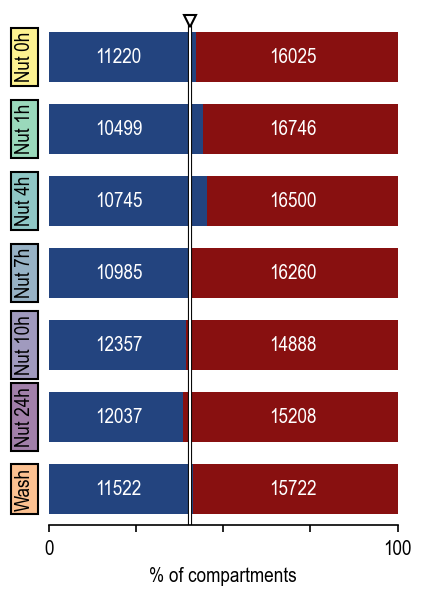

In [24]:
plt.figure(figsize=(3, 4.4), dpi=150)
plt.barh(range(-len(comps), 0), [sum(v < 0 for v in x) / len(x) * 100 for x in comps.values()],
        color="#23447F", height=0.7)

for n, (k, x) in enumerate(comps.items(), 1):
    plt.text(
        20, -n, 
        f"{sum(v < 0 for v in x)}", 
        ha='center', va='center', color='w')
    plt.text(
        70, -n, 
        f"{sum(v > 0 for v in x)}", 
        ha='center', va='center', color='w')
    if 'w' not in k[2]:
        name = f"Nut {k[2]}"
    else:
        name = f"Wash"
    plt.text(
        -7, -n, 
        name, bbox=dict(boxstyle="square", ec=(0, 0, 0, 1), fc=colors[k[2]], 
                alpha=None, pad=0.18),
        ha='center', va='center', color='k', rotation=90)

plt.barh(range(-len(comps), 0), [sum(v > 0 for v in x) / len(x) * 100 for x in comps.values()],
        left=[sum(v < 0 for v in x) / len(x) * 100 for x in comps.values()],
        color="#881010", height=0.7)

med = np.nanmedian([sum(v < 0 for v in x) / len(x) * 100 for x in list(comps.values())[:-2]])

plt.axvline(med, color='k', lw=2)
plt.axvline(med, color='w', lw=1)
plt.plot(med, -0.5, 'v', mec='k', mfc='w', clip_on=False)

plt.xlim(0, 100)
plt.ylim(-len(comps) - 0.5, -0.44)
plt.yticks([])
plt.xticks([0, 25,50, 75, 100], [0, "","", "", 100])
plt.xlabel("% of compartments")
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.savefig("/home/fransua/Projects/Monica_p53/results/compartments/compartment_proportions_S1E_w24h.pdf")